<a href="https://colab.research.google.com/github/tfredrick112/DL-Assignments/blob/master/FashionMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 29 17:11:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Import necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Load the training and validation images, which are stored as rows in a dataframe. We will later reshape each image to get images of shape (28, 28).

In [0]:
dftrain = pd.read_csv('train.csv')
dfval = pd.read_csv('val.csv')

Number of images belonging to each class:

In [4]:
dftrain['label'].value_counts()

7    5550
6    5533
2    5510
1    5503
5    5497
3    5492
8    5485
0    5479
9    5478
4    5473
Name: label, dtype: int64

We see that the images are evenly distributed into all the 10 classes. There is no skew in the dataset, so accuracy will be a good evaluation metric for our classification model.

Defining a few constants:

In [0]:
# number of training examples
M = dftrain.shape[0]

# number of validation examples
Mval = dfval.shape[0]

# dimensions of the image
img_rows = 28
img_cols = 28

# number of classes
num_classes = len(dftrain['label'].value_counts())

Preparing the training and validation dataset and corresponding labels.

In [0]:
# pick only the pixel columns
data_columns = [col for col in list(dftrain.columns) if col not in ['label', 'id']]

dftrain_data = dftrain[data_columns]
dftrain_labels = dftrain['label']

dfval_data = dfval[data_columns]
dfval_labels = dfval['label']

# Training images: X_train is of shape (55000, 28, 28)
X_train = np.array(dftrain_data).reshape((M, img_rows, img_cols, 1))
# Validation images: X_val is of shape (5000, 28, 28)
X_val = np.array(dfval_data).reshape((Mval, img_rows, img_cols, 1))

# Labels for the training examples
y_train = np.array(dftrain_labels)
# Labels for the validation examples
y_val = np.array(dfval_labels)

# Convert the labels to one-hot vectors
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

Import necessary layers, models and callbacks from tensorflow.

In [0]:
import tensorflow as tf
# layers in the CNN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential

# optimizer
from tensorflow.keras.optimizers import Adam

# fine tuning: patience, early stopping, saving the best performing model etc.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Build the model layer-by-layer.

In [0]:
def create_model(choice_init, batch_norm):
    model = Sequential()

    # padding = 'same', because the stride = 1 and kernel_size=(3, 3) and we want a padding of 1 layer.
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     activation='relu', kernel_initializer=choice_init,
                     input_shape=(img_rows, img_cols, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # second convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     activation='relu', kernel_initializer=choice_init))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # third convolutional layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     activation='relu', kernel_initializer=choice_init))

    # fourth convolutional layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     activation='relu', kernel_initializer=choice_init))


    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    # fully connected layers
    model.add(Dense(256, activation='relu', kernel_initializer=choice_init))
    model.add(Dense(1024, activation='relu', kernel_initializer=choice_init))

    # Batch normalization before the softmax layer.
    if batch_norm:
        model.add(BatchNormalization())

    # softmax layer for classification
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=choice_init))
    return model

Compile the model.

In [0]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Actual training step

In [0]:
history = model.fit(X_train, y_train_one_hot, batch_size=50, epochs=10, 
                    verbose=1, validation_data=(X_val, y_val_one_hot))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 249s 5ms/sample - loss: 0.4995 - accuracy: 0.8350 - val_loss: 0.2986 - val_accuracy: 0.8876
Epoch 2/10
55000/55000 [==============================] - 242s 4ms/sample - loss: 0.2849 - accuracy: 0.8963 - val_loss: 0.2754 - val_accuracy: 0.8942
Epoch 3/10
55000/55000 [==============================] - 236s 4ms/sample - loss: 0.2521 - accuracy: 0.9074 - val_loss: 0.2881 - val_accuracy: 0.8974
Epoch 4/10
55000/55000 [==============================] - 242s 4ms/sample - loss: 0.2262 - accuracy: 0.9178 - val_loss: 0.2531 - val_accuracy: 0.9060
Epoch 5/10
55000/55000 [==============================] - 241s 4ms/sample - loss: 0.2038 - accuracy: 0.9255 - val_loss: 0.2473 - val_accuracy: 0.9114
Epoch 6/10
55000/55000 [==============================] - 238s 4ms/sample - loss: 0.1900 - accuracy: 0.9285 - val_loss: 0.2764 - val_accuracy: 0.9006
Epoch 7/10
55000/55000 [===========================

Early Stopping:

In order to prevent overfitting, we must ensure that we do not train the model for too many epochs. We must stop once the validation loss reaches its minimum value. That is precisely the role of EarlyStopping. It **monitors** the validation loss, and stops training when its **minimum** is reached. The role of the **patience** parameter is as follows: Sometimes, we can reach a plateau in the validation loss curve, where the loss remains constant for a few epochs and then starts decreasing again. When we set the patience epoch to 5(for example), we will stop training only if the validation loss does not improve over the next 5 epochs.

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Model Checkpoint

Since we are using 'patience', when we finally stop training, we might not stop at the epoch that gives us the best performing model. The loss curve might have started to increase again within those 'patience' number of epochs. So we can use the ModelCheckpoint class to save the best performing model.

In [0]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Plotting Loss curves

In [0]:
def plot_loss_curves(history):
    x_axis = list(range(1, len(history.history['loss'])+1))
    plt.plot(x_axis, history.history['loss'], color='red', label='Training Loss')
    plt.plot(x_axis, history.history['val_loss'], color='lime', label='Validation Loss')
    plt.title('Training Loss and Validation Loss', size=18)
    plt.xlabel('Number of epochs', size=14)
    plt.ylabel('Loss', size=14)
    plt.legend()
    plt.grid()
    plt.show()

Putting everything together

In [0]:
def train_model(X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=50, 
                num_epochs=20, choice_init='glorot_uniform', batch_norm=True):
    # Create the model
    fashion_mnist = create_model(choice_init, batch_norm)
    
    # Compile the model
    adam = Adam(learning_rate=learning_rate)
    fashion_mnist.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Early stopping with patience and model checkpoint
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    # Fit training data
    history = fashion_mnist.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, 
                                verbose=1, validation_data=(X_val, y_val), callbacks=[es, mc])
    
    # plot graphs
    plot_loss_curves(history)
    return history

Epoch 1/20
1098/1100 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8441
Epoch 00001: val_accuracy improved from -inf to 0.81720, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4361 - accuracy: 0.8441 - val_loss: 0.4966 - val_accuracy: 0.8172
Epoch 2/20
1100/1100 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8987
Epoch 00002: val_accuracy improved from 0.81720 to 0.89640, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2826 - accuracy: 0.8987 - val_loss: 0.2944 - val_accuracy: 0.8964
Epoch 3/20
1100/1100 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9151
Epoch 00003: val_accuracy did not improve from 0.89640
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2360 - accuracy: 0.9151 - val_loss: 0.2873 - val_accuracy: 0.8942
Epoch 4/20
1093/1100 [============================>.] - ETA: 0s - loss: 0.2

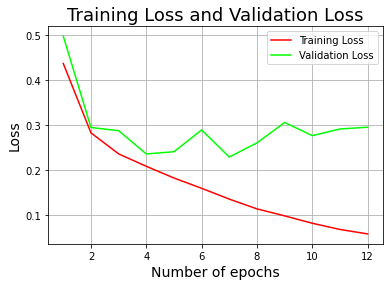

In [23]:
lr = 0.001
batch_size = 50
max_epochs = 20
choice_init = 'glorot_uniform'
batch_norm = True

train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

In [25]:
from tensorflow.keras.models import load_model

def accuracy_score():
  best_model = load_model('best_model.h5')
  _, train_acc = best_model.evaluate(X_train, y_train_one_hot, verbose=0)
  _, val_acc = best_model.evaluate(X_val, y_val_one_hot, verbose=0)
  print("Training accuracy: {}%".format(round(train_acc*100, 3)))
  print("Validation accuracy: {}%".format(round(val_acc*100, 3)))

accuracy_score()

Training accuracy: 98.222%
Validation accuracy: 92.48%


For the following parameters:
```
lr = 0.001
batch_size = 50
max_epochs = 20
choice_init = 'glorot_uniform'
batch_norm = True
```

We get: 
```
Training accuracy: 98.222%
Validation accuracy: 92.48%
The training stops after 12 epochs.
```

He initialization:

Epoch 1/30
1094/1100 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8311
Epoch 00001: val_accuracy improved from -inf to 0.75440, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4643 - accuracy: 0.8312 - val_loss: 1.2451 - val_accuracy: 0.7544
Epoch 2/30
1092/1100 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8881
Epoch 00002: val_accuracy improved from 0.75440 to 0.89340, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.3109 - accuracy: 0.8884 - val_loss: 0.3183 - val_accuracy: 0.8934
Epoch 3/30
1099/1100 [============================>.] - ETA: 0s - loss: 0.2502 - accuracy: 0.9098
Epoch 00003: val_accuracy did not improve from 0.89340
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2502 - accuracy: 0.9098 - val_loss: 5.8260 - val_accuracy: 0.6752
Epoch 4/30
1097/1100 [============================>.] - ETA: 0s - loss: 0.2

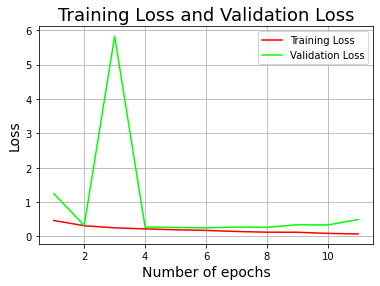

In [26]:
lr = 0.001
batch_size = 50
max_epochs = 30
choice_init = 'he_uniform'
batch_norm = True

train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

In [27]:
accuracy_score()

Training accuracy: 97.9%
Validation accuracy: 92.3%


For the following parameters:
```
lr = 0.001
batch_size = 50
max_epochs = 30
choice_init = 'he_uniform'
batch_norm = True
```

We get: 
```
Training accuracy: 97.9%
Validation accuracy: 92.3%
The training stops after 11 epochs.
```

**Conclusion:** Xavier initialization performs marginally better than He initialization as demonstrated above.

Let us check what happens if we do not use BatchNormalization before the final layer.

Epoch 1/50
1096/1100 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8381
Epoch 00001: val_accuracy improved from -inf to 0.88680, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4945 - accuracy: 0.8382 - val_loss: 0.3074 - val_accuracy: 0.8868
Epoch 2/50
1098/1100 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8948
Epoch 00002: val_accuracy improved from 0.88680 to 0.89320, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2884 - accuracy: 0.8948 - val_loss: 0.2921 - val_accuracy: 0.8932
Epoch 3/50
1100/1100 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9071
Epoch 00003: val_accuracy improved from 0.89320 to 0.90440, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2525 - accuracy: 0.9071 - val_loss: 0.2516 - val_accuracy: 0.9044
Epoch 4/50
1099/1100 [==================

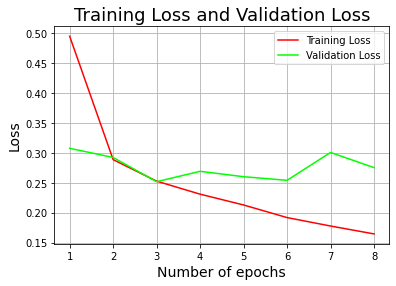

In [28]:
lr = 0.001
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = False

train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

In [29]:
accuracy_score()

Training accuracy: 93.04%
Validation accuracy: 90.88%


For the following parameters:
```
lr = 0.001
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = False
```

We get: 
```
Training accuracy: 93.04%
Validation accuracy: 90.88%
The training stops after 8 epochs.
```

**Conclusion** : Without BatchNormalization, overfitting starts very early, in epoch 8 itself. That is why the training stopped at epoch 8. The training error will keep decreasing, but the validation error will remain stationary for a few epochs and then start increasing due to overfitting.

In order to see this, let us use the train_model() function without the effect of early stopping.

Epoch 1/50
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4800 - accuracy: 0.8394 - val_loss: 0.3108 - val_accuracy: 0.8856
Epoch 2/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2841 - accuracy: 0.8953 - val_loss: 0.2827 - val_accuracy: 0.9008
Epoch 3/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2496 - accuracy: 0.9097 - val_loss: 0.2643 - val_accuracy: 0.9078
Epoch 4/50
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2252 - accuracy: 0.9159 - val_loss: 0.2505 - val_accuracy: 0.9084
Epoch 5/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2090 - accuracy: 0.9226 - val_loss: 0.2627 - val_accuracy: 0.9096
Epoch 6/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.1915 - accuracy: 0.9286 - val_loss: 0.2470 - val_accuracy: 0.9122
Epoch 7/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.1824 - accuracy: 0.9321 - val_loss: 0.2700 - val_accuracy:

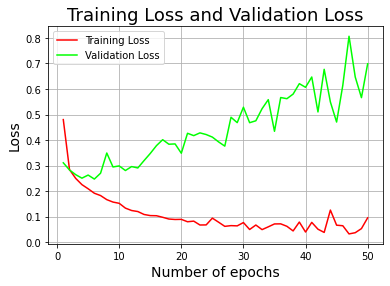

In [31]:
def train_model_no_earlystop(X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=50, 
                num_epochs=20, choice_init='glorot_uniform', batch_norm=True):
    # Create the model
    fashion_mnist = create_model(choice_init, batch_norm)
    
    # Compile the model
    adam = Adam(learning_rate=learning_rate)
    fashion_mnist.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit training data
    history = fashion_mnist.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, 
                                verbose=1, validation_data=(X_val, y_val))
    
    # plot graphs
    plot_loss_curves(history)
    return history

lr = 0.001
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = False

history = train_model_no_earlystop(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

The above graph shows that overfitting started somewhere around epoch 7 or 8. That is why, when we used early stopping callback, the training stopped at epoch number 8.

Let us now see the effect of changing the batch size.

Epoch 1/50
5497/5500 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.7720
Epoch 00001: val_accuracy improved from -inf to 0.76880, saving model to best_model.h5
5500/5500 [==============================] - 21s 4ms/step - loss: 0.6391 - accuracy: 0.7720 - val_loss: 2.1075 - val_accuracy: 0.7688
Epoch 2/50
5487/5500 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8672
Epoch 00002: val_accuracy improved from 0.76880 to 0.89260, saving model to best_model.h5
5500/5500 [==============================] - 21s 4ms/step - loss: 0.3813 - accuracy: 0.8673 - val_loss: 0.3580 - val_accuracy: 0.8926
Epoch 3/50
5489/5500 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8842
Epoch 00003: val_accuracy did not improve from 0.89260
5500/5500 [==============================] - 21s 4ms/step - loss: 0.3300 - accuracy: 0.8842 - val_loss: 0.5925 - val_accuracy: 0.8882
Epoch 4/50
5490/5500 [============================>.] - ETA: 0s - loss: 

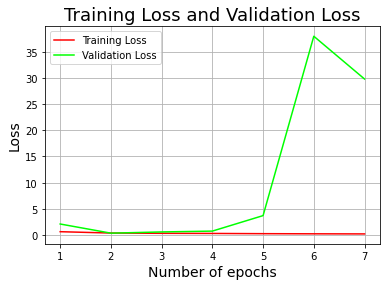

In [32]:
lr = 0.001
batch_size = 10
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True

train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

Having a smaller batch size makes the validation curve very jumpy.

In [33]:
accuracy_score()

Training accuracy: 93.567%
Validation accuracy: 91.12%


Change in the learning rate

Epoch 1/50
1099/1100 [============================>.] - ETA: 0s - loss: 0.6534 - accuracy: 0.7636
Epoch 00001: val_accuracy improved from -inf to 0.74260, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.6533 - accuracy: 0.7637 - val_loss: 0.7866 - val_accuracy: 0.7426
Epoch 2/50
1100/1100 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8667
Epoch 00002: val_accuracy improved from 0.74260 to 0.87200, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.3684 - accuracy: 0.8667 - val_loss: 0.3619 - val_accuracy: 0.8720
Epoch 3/50
1093/1100 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8913
Epoch 00003: val_accuracy improved from 0.87200 to 0.89780, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.3025 - accuracy: 0.8914 - val_loss: 0.2869 - val_accuracy: 0.8978
Epoch 4/50
1099/1100 [==================

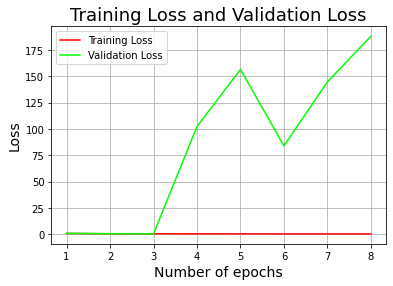

In [38]:
lr = 0.01
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True

history = train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

For a learning rate of 0.01, the validation loss curve is very wavy, due to the large updates in the paramters at every gradient descent step. The model overshoots the minima and possibly oscillates around the minima also, which is why we get very large loss values at some epochs.

Epoch 1/50
1097/1100 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8563
Epoch 00001: val_accuracy improved from -inf to 0.86240, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4032 - accuracy: 0.8563 - val_loss: 0.4118 - val_accuracy: 0.8624
Epoch 2/50
1096/1100 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.9021
Epoch 00002: val_accuracy improved from 0.86240 to 0.87760, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2706 - accuracy: 0.9023 - val_loss: 0.3451 - val_accuracy: 0.8776
Epoch 3/50
1096/1100 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9176
Epoch 00003: val_accuracy improved from 0.87760 to 0.91020, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2263 - accuracy: 0.9176 - val_loss: 0.2746 - val_accuracy: 0.9102
Epoch 4/50
1099/1100 [==================

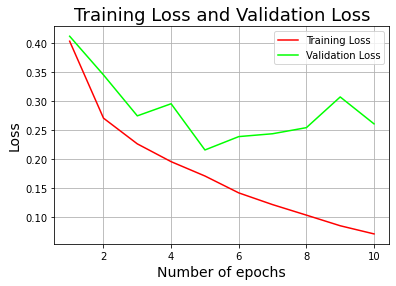

In [39]:
lr = 0.0005
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True

history = train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

In [40]:
accuracy_score()

Training accuracy: 95.709%
Validation accuracy: 92.82%


For the following parameters:
```
lr = 0.0005
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True
```

We get: 
```
Training accuracy: 95.709%
Validation accuracy: 92.82%
The training stops after 10 epochs.
```

The accuracy is a slight improvement over the case where we used learning rate of 0.001.

Epoch 1/50
1096/1100 [============================>.] - ETA: 0s - loss: 0.4366 - accuracy: 0.8469
Epoch 00001: val_accuracy improved from -inf to 0.84720, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.4364 - accuracy: 0.8469 - val_loss: 0.4466 - val_accuracy: 0.8472
Epoch 2/50
1099/1100 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8922
Epoch 00002: val_accuracy improved from 0.84720 to 0.86200, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2990 - accuracy: 0.8921 - val_loss: 0.3847 - val_accuracy: 0.8620
Epoch 3/50
1094/1100 [============================>.] - ETA: 0s - loss: 0.2480 - accuracy: 0.9113
Epoch 00003: val_accuracy improved from 0.86200 to 0.88840, saving model to best_model.h5
1100/1100 [==============================] - 7s 6ms/step - loss: 0.2480 - accuracy: 0.9113 - val_loss: 0.3270 - val_accuracy: 0.8884
Epoch 4/50
1093/1100 [==================

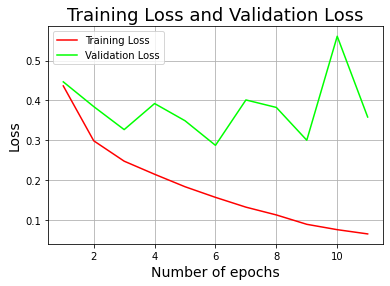

In [41]:
lr = 0.0001
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True

history = train_model(X_train, y_train_one_hot, X_val, y_val_one_hot, learning_rate=lr, batch_size=batch_size, 
            num_epochs=max_epochs, choice_init=choice_init, batch_norm=batch_norm)

In [42]:
accuracy_score()

Training accuracy: 97.438%
Validation accuracy: 92.34%


For the following parameters:
```
lr = 0.0001
batch_size = 50
max_epochs = 50
choice_init = 'glorot_uniform'
batch_norm = True
```

We get: 
```
Training accuracy: 97.438%
Validation accuracy: 92.34%
The training stops after 10 epochs.
```

**CONCLUSION:** We can see that the best results are obtained by using Xaiver initialization, a batch size of 50, early stopping to avoid overfitting, learning rate = 0.0005. The use of batch normalization also helps mitigate the problem of overfitting.